### **1. LLN**
###### **The strongest version of the classical LLN, known as Kolmogorov's strong law, states that if $X_1, X_2,...,X_3$ are i.i.d scalar random variables, with common distribution $F$, with common mean of $\mu$: $$\mu = E[x] = \int x F(dx)$$ and sample average: $$\bar{X_n} = \sum_{i=1}^{n} X_i$$ moreover, if $E[|x|]$ is finite, then $$P\{\bar{X}_n \to \mu \text{ as } n \to \infty\} = 1$$** 
###### **A weaker version of the LLN states that if $X_1, X_2,...,X_3$ are i.i.d with $E[X_i^2] < \infty$ then, for any $\epsilon > 0$, we have: $$P\{|\bar{X}_n - \mu| \geq \epsilon\} \to 0 \text{ as } n \to \infty$$** 
###### **This version is weaker because we claim only convergence in probability rather than almost sure convergence, and assume a fnite second moment.**

#### **1.1 LLN in Action**
###### **Draw $N = 1000$ samples from $X \sim N(4,1$). Use $for\;loop$ to find average of the first $i$ samples, for all $i$. Then draw sample average and population average.**
###### **Do the same exercise without using for $for\;loop$ and set $N = 1000$  using lower triangular matrix of ones. Then repeat this for the following population distributions:<br> $X \sim Uniform(2,5), X \sim Gamma(6, \dfrac{1}{3}) , X \sim LogNormal(3, 4)$. Plot the histogram and the kernel density function for each.**

In [1082]:
import numpy as np
from numpy.random import normal, uniform, gamma, lognormal, standard_cauchy, choice, shuffle
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit, njit, prange
from scipy.misc import derivative
import cupy as cp
import seaborn as sns
import scipy.stats as st
from tqdm import tqdm
import time
from scipy.linalg import sqrtm
from scipy.optimize import fsolve
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def lln_in_action(n, dist, method, params, plots):
    ''' 
    n: Number of Sample
    
    dist: A distribution from set of {normal, uniform, gamma, lognormal, standard_cauchy, choice}
    
    method: Either "loop" or "matrix"

    params: A list which contains parameters
    
    plots: If "not_mixture", Convergence to Population Average, Histogram of Averages, and Kernel Density of Averages will be plotted, 
    while if "mixture" Convergence to Population Average, Histogram of Random Sample and Kernel Density of Random Sample will be plotted 

    '''
    np.random.seed(5445)
    
    if str(dist).split()[2] in ['normal', 'lognormal']:
        random_sample = dist(params[0], np.sqrt(params[1]), n)

    elif str(dist).split()[2] == 'gamma':
        random_sample = dist(params[0], 1/params[1], n)

    elif str(dist).split()[2] == 'standard_cauchy':
        random_sample = dist(n)
    
    elif str(dist).split()[2] == 'choice':
        population_a, population_b = normal(params[0],params[1],int(n*params[2])), normal(params[3],params[4],int(n*params[5])) 
        random_sample = np.hstack([population_a, population_b])
        shuffle(random_sample)

    else:
        random_sample = dist(params[0], params[1], n)

    if method == 'loop':
        sample_avgs = np.zeros(n,)
        for i in range(n):
            sample_avgs[i] = random_sample[:i+1].mean()

    else:
        lt_matrix = np.tril(np.ones((n,n), dtype=np.int8))
        sample_avgs = (lt_matrix @ random_sample.reshape(-1,1)) / lt_matrix.sum(1).reshape(-1,1)
        sample_avgs = sample_avgs.reshape(n, )

    # Let's use theoretical expectations instead of whole sample average
    if str(dist).split()[2] == 'normal':
        population_mean = params[0]

    elif str(dist).split()[2] == 'uniform':
        population_mean = np.mean(params)
    
    elif str(dist).split()[2] == 'gamma':
        population_mean = params[0] / params[1]

    elif str(dist).split()[2] == 'lognormal':
        population_mean = np.exp(params[0] + params[1]/2)
    
    elif str(dist).split()[2] == 'choice':
        population_mean = params[0] * params[2] + params[3] * params[5] 

    else:
        population_mean = sample_avgs.mean()

    if plots == 'not_mixture':
        plt.subplot(1,3,1)
        sns.lineplot(x = range(1, n+1), y = sample_avgs, color = 'blue', label='Sample Average')
        plt.axhline(y=population_mean, color='red', ls='--', label='Population Average')
        plt.gca().set_xlabel("Number of Samples")
        plt.gca().set_ylabel("Sample Average")
        plt.title('Convergence of Samples Averages to Population Average', fontsize=10)
        plt.legend(bbox_to_anchor=(-0.15, 1))


        plt.subplot(1,3,2)
        sns.histplot(sample_avgs, color = 'blue')
        plt.gca().set_xlabel("Sample Average")
        plt.title('Histogram of Samples Averages', fontsize=10)
        plt.axvline(x=population_mean, color='red', ls='--', label='Population Average')

        plt.subplot(1,3,3)
        sns.kdeplot(sample_avgs, color = 'blue')
        plt.gca().set_xlabel("Sample Average")
        plt.title('Kernel Density of Samples Averages', fontsize=10)
        plt.axvline(x=population_mean, color='red', ls='--', label='Population Average')

        plt.suptitle(f"{str(dist).split()[2].capitalize()} Distribution", fontsize=16, fontweight='bold', y=1.05) 

        plt.gcf().set_size_inches(15,4)

    else:
        plt.subplot(1,3,1)
        sns.lineplot(x = range(1, n+1), y = sample_avgs, color = 'blue', label='Sample Average')
        plt.axhline(y=population_mean, color='red', ls='--', label='Population Average')
        plt.gca().set_xlabel("Number of Samples")
        plt.gca().set_ylabel("Sample Average")
        plt.title('Convergence of Samples Averages to Population Average', fontsize=10)
        plt.legend(bbox_to_anchor=(-0.15, 1))

        plt.subplot(1,3,2)
        sns.histplot(random_sample, color = 'blue')
        plt.gca().set_xlabel("Random Sample")
        plt.title('Histogram of Random Sample', fontsize=10)
        plt.axvline(x=population_mean, color='red', ls='--', label='Population Average')

        plt.subplot(1,3,3)
        sns.kdeplot(random_sample, color = 'blue')
        plt.gca().set_xlabel("Random Sample")
        plt.title('Kernel Density of Random Sample', fontsize=10)
        plt.axvline(x=population_mean, color='red', ls='--', label='Population Average')

        plt.suptitle(f"Mixture of Distributions", fontsize=16, fontweight='bold', y=1.05) 

        plt.gcf().set_size_inches(15,4)

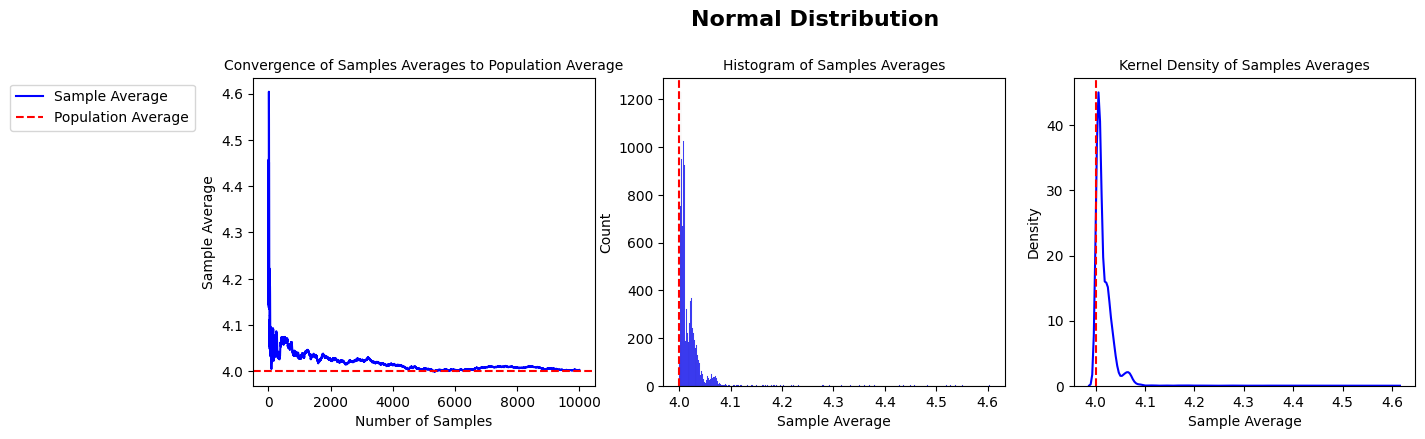

In [92]:
lln_in_action(n=int(1e4), dist=normal, method='loop', params=[4,1], plots='not_mixture')

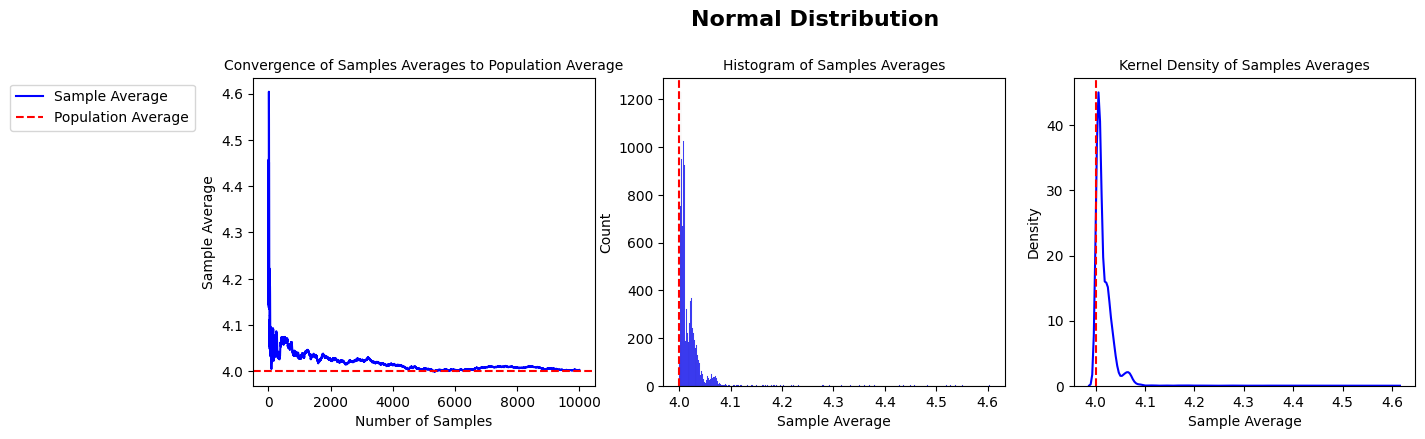

In [93]:
lln_in_action(n=int(1e4), dist=normal, method='matrix', params=[4,1], plots='not_mixture')

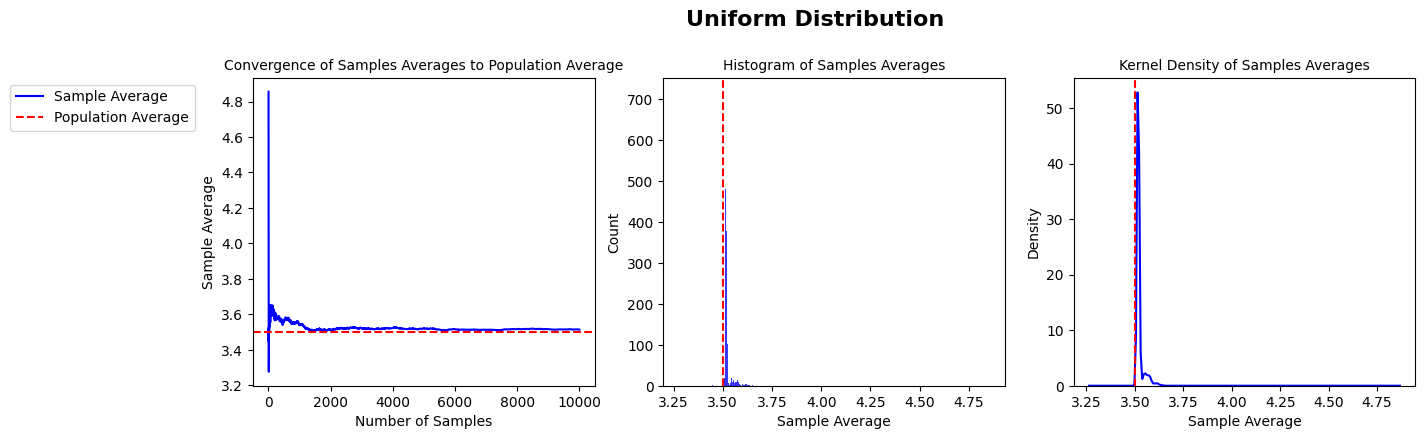

In [94]:
lln_in_action(n=int(1e4), dist=uniform, method='matrix', params=[2,5], plots='not_mixture')

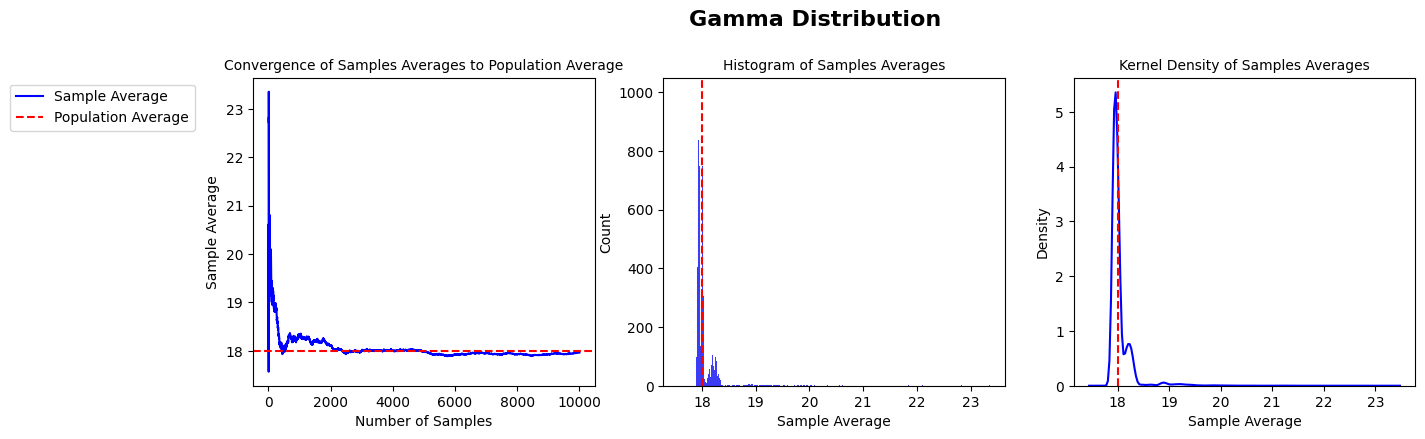

In [95]:
lln_in_action(n=int(1e4), dist=gamma, method='matrix', params=[6,1/3], plots='not_mixture')

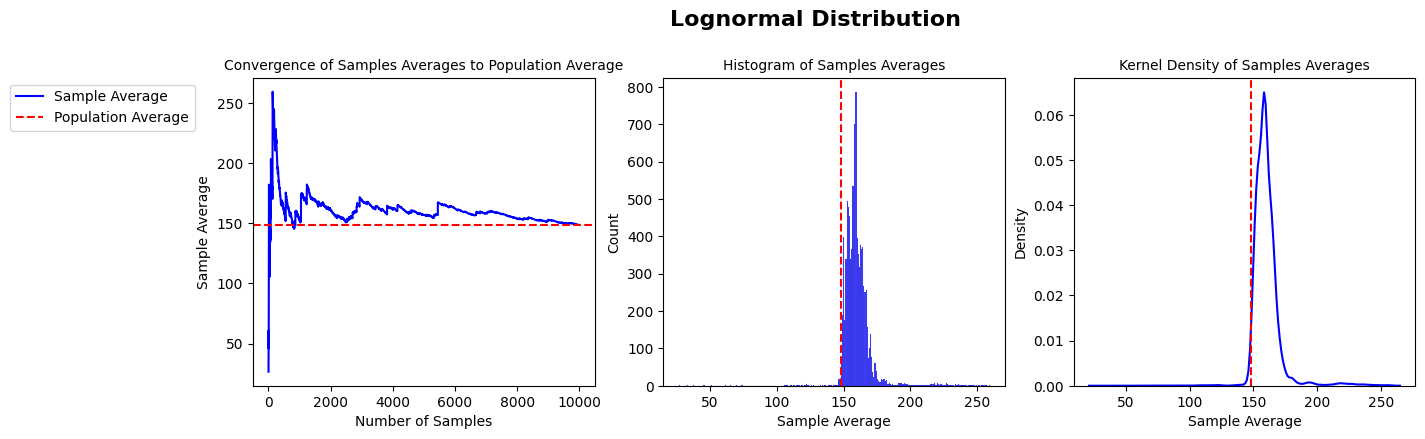

In [96]:
lln_in_action(n=int(1e4), dist=lognormal, method='matrix', params=[3,4], plots='not_mixture')

#### 1.2 LLN Fails?
###### **Try to repeat the same exercise with a Cauchy distribution: $f(x) = \dfrac{1}{\pi(1+x^2)}$. Does the sample average converge to the population mean? Does the population mean even exist? Increase the number of observations to N = 104. Do you see any convergence? Interpret.**

###### An interesting feature of Cauchy distribution is that it has no finite integer moments, and that is why LLN does not hold here and the samples averages will not coverge to a constant in probability. For more interesting debates about this feature please read: 
###### https://stats.stackexchange.com/questions/36027/why-does-the-cauchy-distribution-have-no-mean 

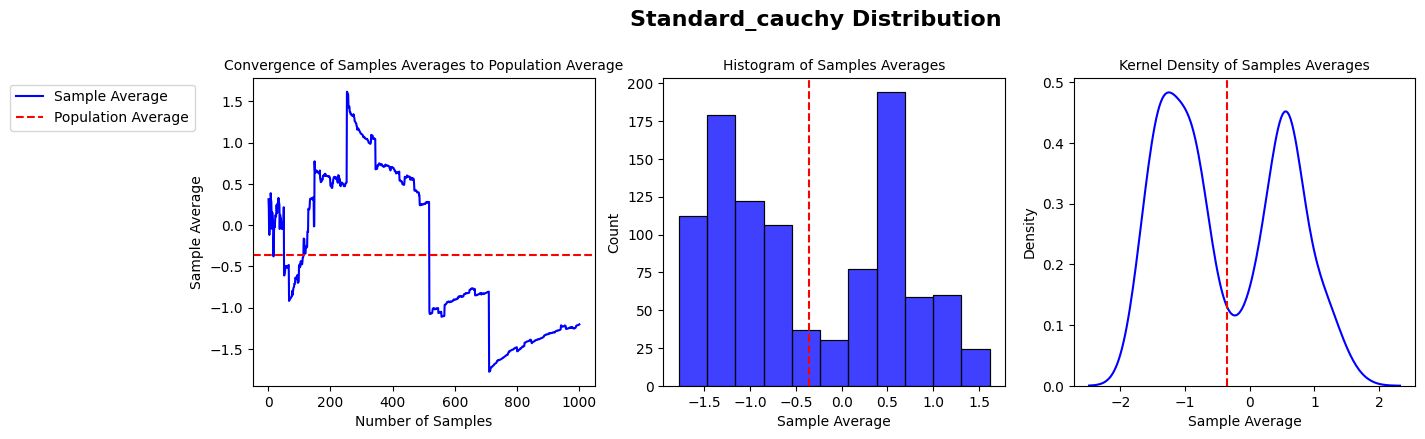

In [97]:
lln_in_action(n=int(1e3), dist=standard_cauchy, method='matrix', params= None , plots='not_mixture')

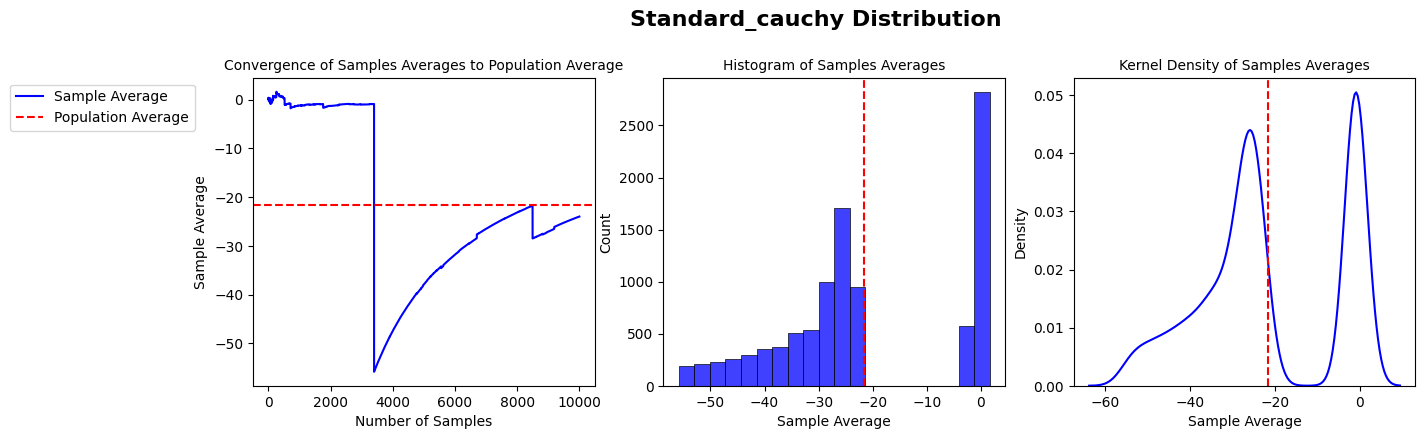

In [98]:
lln_in_action(n=int(1e4), dist=standard_cauchy, method='matrix', params= None , plots='not_mixture')

#### **1.3 True story**
###### **Assume $X_A \sim N(30, 1)$ and $X_B \sim N(-70, 1)$. The economy is randomly populated with 70 percent of type-A people and the rest are type-B people. A researcher is drawing from this population. What would be the true average and variance of the population? Draw N = 1000 observations from this population. Plot the histogram and the kernel density function. Then use your code from previous part to see whether the sample average converges to the population average. Does LLN fail? Interpret.**

###### Theoretically, for $X_C$, defined as a population with 70 percent of type-A people and 30 percent type-B people, $E[X_C] = 0.7 \cdot E[X_A] + 0.3 \cdot E[X_B] = 0$ and $Var[X_C] = (0.7 \cdot Var[X_A] + 0.3 \cdot Var[X_B]) + (0.7 \cdot (E[X_A] - E[X_c])^2 + 0.3 \cdot (E[X_B]- E[X_c])^2) = 1 + 2100 = 2101$ 
###### In this case, LLN will not fail as it states that when $N \to \infty$ the sample mean will converge to the population mean $E[X] = 0$. However, as our population is the mixture of two very different population and has a very large variance, the convergence will be unstable for small $N$, therefore we need large enough $N$ to get the convergence.

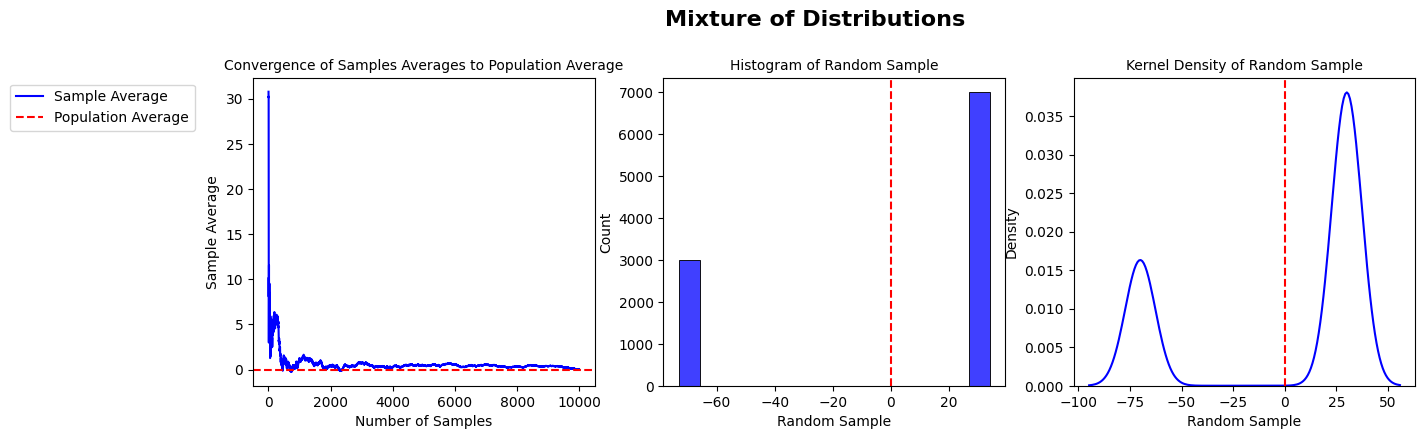

In [102]:
lln_in_action(n=int(1e4), dist=choice, method='matrix', params= [30, 1, 0.7,     -70, 1, 0.3] , plots='mixture')

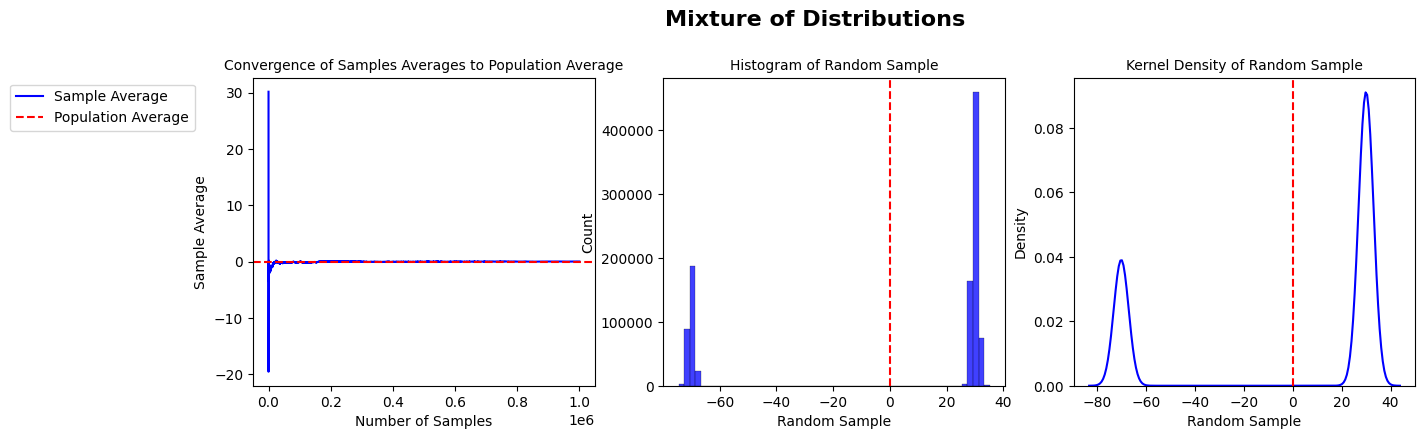

In [105]:
lln_in_action(n=int(1e6), dist=choice, method='loop', params= [30, 1, 0.7,     -70, 1, 0.3] , plots='mixture')

### **2. CLT**
###### **The central limit theorem states that if $X_1, X_2,...,X_3$ are i.i.d random variables, with common mean $\mu$ and common variance $\sigma^2 \in (0, \infty)$, then:  $$\sqrt{n} (\bar{X}_n - \mu) \xrightarrow{d} N(0, \sigma^2) \text{ as } n \to \infty$$ The amazing implication of the CLT is that for *any* distribution with finite second moment, the standardized sum $Z_n = \sqrt{n} (\bar{X}_n - \mu)$ is approximately normally distributed and that the normal approximation improves as $n$ increases.**
###### **Another way to understand this concept is to say, if we draw $n$ samples from any distrubtion, get the average of these $n$ sample, and repeat this process for $k$ times, meaning we eventually have $k$ averages, the distribution of this $k$ averages approaches normal.** 

In [52]:
def clt(n, k, dist, params, standard_normal = False):

    np.random.seed(5445)
    
    if str(dist).split('.')[-1].split()[0] == 'norm_gen':
        distribution = dist(loc = params[0], scale = np.sqrt(params[1]))

    elif str(dist).split('.')[-1].split()[0] == 'gamma_gen':
        distribution = dist(a = params[0], scale = 1/params[1])
    
    elif str(dist).split('.')[-1].split()[0] == 'uniform_gen':
        distribution = dist(loc = params[0], scale = params[1] - params[0])

    elif str(dist).split('.')[-1].split()[0] == 'lognorm_gen':
         distribution = dist(s = np.sqrt(params[1]), scale = np.exp(params[0]))


    population_mean, population_std = distribution.mean(), distribution.std()

    random_sample = distribution.rvs((k,n))
    sample_avg = random_sample.mean(-1)

    if standard_normal:
        clt_dist = np.sqrt(n) * (sample_avg - population_mean) / population_std
    else:
        clt_dist = np.sqrt(n) * (sample_avg - population_mean)

    sns.histplot(clt_dist, color = 'blue', kde=True, label = '$Normal \sim (0, \sigma ^2)$')
    plt.legend()
    plt.title(f"{str(dist).split('.')[-1].split()[0].split('_')[0].capitalize()} Distribution", fontsize=16, fontweight='bold', y=1.05) 
    plt.gcf().set_size_inches(7,4)

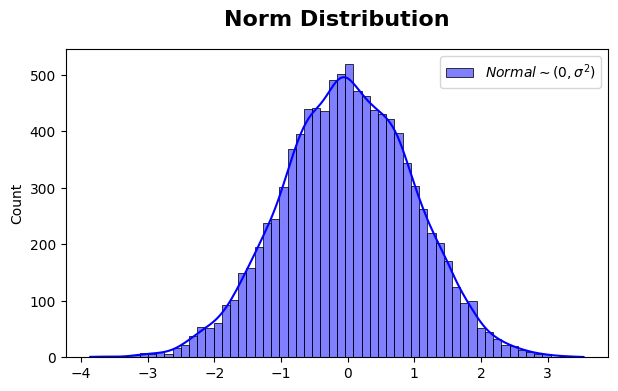

In [53]:
clt(n = int(1e4), k = int(1e4), dist = st.norm, params=[4,1])

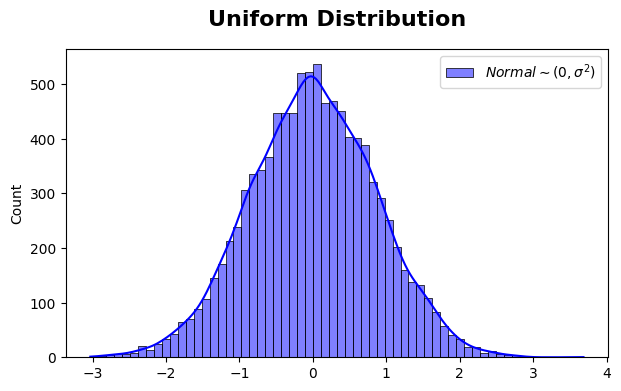

In [54]:
clt(n = int(1e4), k = int(1e4), dist = st.uniform, params=[2,5])

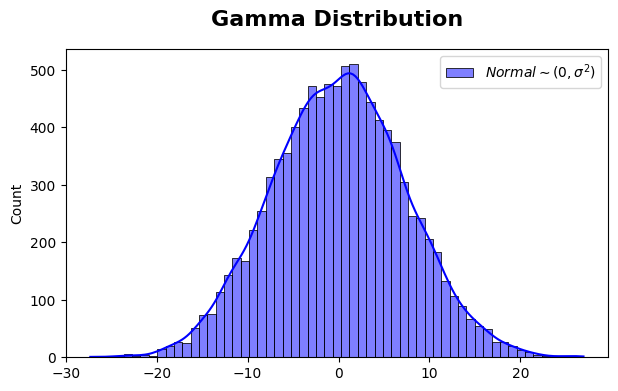

In [59]:
clt(n = int(1e4), k = int(1e4), dist = st.gamma, params=[6,1/3])

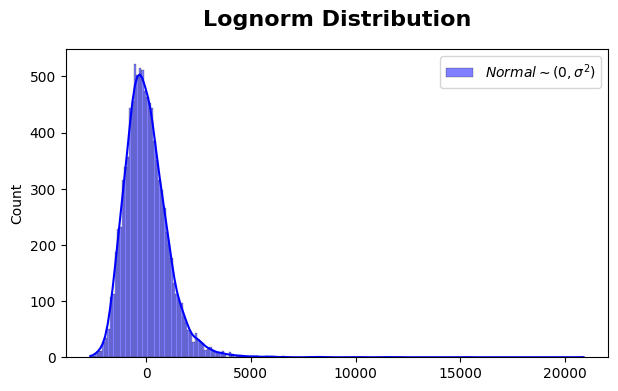

In [56]:
clt(n = int(1e4), k = int(1e4), dist = st.lognorm, params=[3,4])

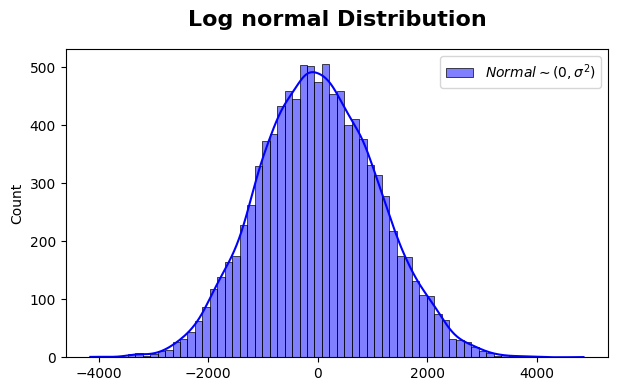

In [ ]:
#For such a heavy tailed distribution, we need to draw many samples to see the convergence, therefore here I use parallel computation
@njit(parallel=True)
def clt_lognormal(n, k, loc, scale):
    sample_avg = np.zeros(k,)
    population_mean = np.exp(loc + scale/2)
    for i in prange(k):
        sample_avg[i] = np.mean(lognormal(loc, np.sqrt(scale), n))
    clt_dist = np.sqrt(n) * (sample_avg - population_mean)
    return clt_dist

clt_dist = clt_lognormal(n = int(1e7), k = int(1e4), loc = 3, scale = 4)
sns.histplot(clt_dist, color = 'blue', kde=True, label = '$Normal \sim (0, \sigma ^2)$')
plt.legend()
plt.title(f"Log normal Distribution", fontsize=16, fontweight='bold', y=1.05) 
plt.gcf().set_size_inches(7,4)

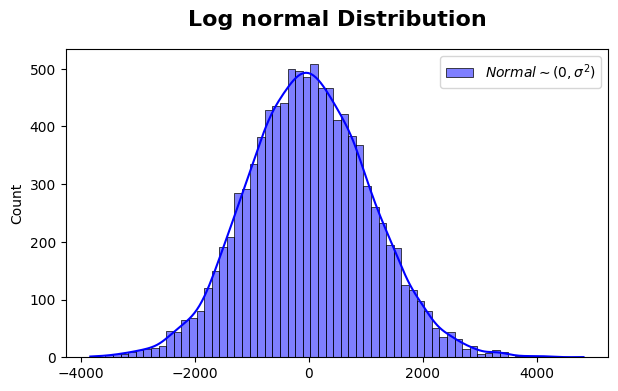

In [ ]:
#If we have gpu, let's use cupy to speed up the process
def clt_lognormal_gpu(n, k, loc, scale):

    population_mean = np.exp(loc + scale / 2)
    
    sample_avgs_gpu = cp.zeros(k, dtype=cp.float64)
    
    for i in range(k):
        samples_gpu = cp.random.lognormal(mean=loc, sigma=cp.sqrt(scale), size=n)
        sample_avgs_gpu[i] = samples_gpu.mean()
    
    sample_avgs = sample_avgs_gpu.get()  
    
    clt = np.sqrt(n) * (sample_avgs - population_mean)
    
    return clt

clt_dist = clt_lognormal_gpu(int(1e7), int(1e4), 3, 4)

sns.histplot(clt_dist, color = 'blue', kde=True, label = '$Normal \sim (0, \sigma ^2)$')
plt.legend()
plt.title(f"Log normal Distribution", fontsize=16, fontweight='bold', y=1.05) 
plt.gcf().set_size_inches(7,4)

### **3. More on CLT and LLN**

#### **3.1**
###### **One very useful consequence of the central limit theorem is as follows. if $g:R \to R$ is differentiable at $\mu$ and $g'(\mu) \neq 0$  then $$\sqrt{n} \{ g(\bar{X}_n) - g(\mu) \} \xrightarrow{d} N(0, g'(\mu)^2 \sigma^2) \quad \text{as} \quad n \to \infty$$ This theorem is used frequently in statistics to obtain the asymptotic distribution of estimators, many of which can be expressed as functions of sample means (These kinds of results are often said to use the  *delta method*). The proof is based on a Taylor expansion of around the point.** 
###### **Take the result as given, let the distribution $F$ of each $X_i$ be uniform on $[0,\dfrac{\pi}{2}]$ and let $g(x) = \sin{x}$ Derive the asymptotic distribution of $\sqrt{n} \{ g(\bar{X}_n) - g(\mu) \}$ and illustrate convergence.**
###### **What happens when you replace $[0,\dfrac{\pi}{2}]$ with $[0,\pi]$. What is the source of the problem?**
###### When we replace $[0,\dfrac{\pi}{2}]$ with $[0,\pi]$, we are violating the condition of theorem, stating that $g'(\mu) \neq 0$; however, $g'(\pi) = \sin'{\pi} = \cos{\pi} = 0$



Theoretical Variance: 0.1028, Empirical Variance: 0.1019


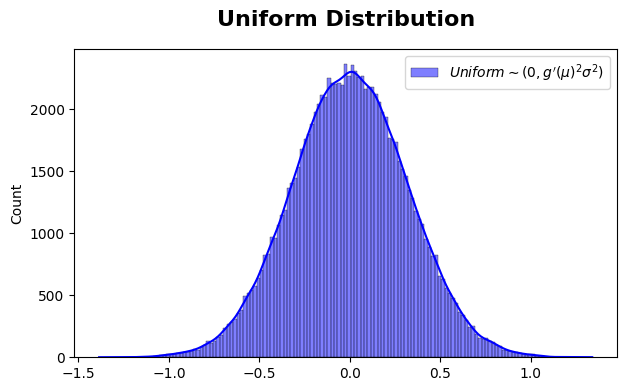

In [ ]:
def clt_extension(n, k, low, high, function):

    population_mean = (high + low) / 2
    population_variance = (high - low)**2 / 12

    sample_avgs_gpu = cp.zeros(k)
    
    for i in range(k):
        samples_gpu = cp.random.uniform(low=low, high=high, size=n)
        sample_avgs_gpu[i] = function(samples_gpu.mean())    
    
    clt = cp.sqrt(n) * (sample_avgs_gpu - function(population_mean))
    
    theoretical_var = derivative(function, population_mean, dx=1e-6).item()**2 * population_variance
    empirical_var = clt.var().item()

    print(f"Theoretical Variance: {theoretical_var:.4f}, Empirical Variance: {empirical_var:.4f}")

    return clt.get() 

clt_dist = clt_extension(int(1e6), int(1e5), 0, cp.pi/2, lambda x: cp.sin(x))
sns.histplot(clt_dist, color = 'blue', kde=True, label = "$Uniform \sim (0, g'(\mu)^2 \sigma ^2)$")
plt.legend()
plt.title(f"Uniform Distribution", fontsize=16, fontweight='bold', y=1.05) 
plt.gcf().set_size_inches(7,4)

Theoretical Variance: 0.0000, Empirical Variance: 0.0000


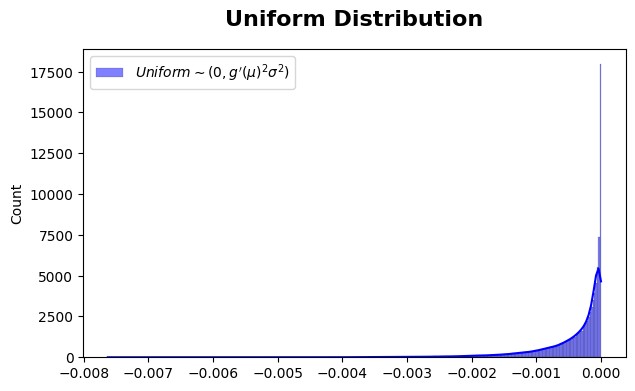

In [ ]:
#In case of violation of delta method assumption
clt_dist = clt_extension(int(1e6), int(1e5), 0, cp.pi, lambda x: cp.sin(x))
sns.histplot(clt_dist, color = 'blue', kde=True, label = "$Uniform \sim (0, g'(\mu)^2 \sigma ^2)$")
plt.legend()
plt.title(f"Uniform Distribution", fontsize=16, fontweight='bold', y=1.05) 
plt.gcf().set_size_inches(7,4)

#### **3.2**
###### **Here's a result that's often used in developing statistical tests, and is connected to the multivariate central limit theorem. Assume the setting of the multivariate CLT, so that**
###### **1. $X_1, ..., X_n$ is a sequence of i.i.d random vectors, each taking values in $R^k$** 
###### **2. $\mu = E[X_i]$ and $\Sigma$ is the variance-covariance matrix of $X_i$**
###### **3. The convergence $\sqrt{n} (\bar{X}_n - \mu) \xrightarrow{d} N(0, \Sigma)$**
###### **is valid**
###### **In a statistical setting, one often wants the right-hand side to be standard normal so that confidence intervals are easily computed. This normalization can be achieved on the basis of three observations. First, if $X$ is a random vector in $R^k$ and $A$ is constant and $k \times k$ then $$Var[AX] = A Var[X] A'$$ Second, by the continuous mapping theorem, if $Z_n \xrightarrow{d} Z$ in $R^k$ and $A$ is constant and $k \times k$ then  $$AZ_n \xrightarrow{d} AZ$$ Third, if $S$ is a $k \times k$ symmetric positive definite matrix, then there exists a symmetric positive definite matrix $Q$ called the inverse square root of $S$ , such that $$QSQ' = I$$ Here $I$ is $k \times k$  identity matrix. Putting these things together, we can show that if $Q$ is the inverse square root of $\Sigma$, then $$\mathbf{Z}_n := \sqrt{n} \mathbf{Q} (\bar{\mathbf{X}}_n - \mu) \xrightarrow{d} \mathbf{Z} \sim N(0, \mathbf{I})$$ Applying the continuous mapping theorem one more time tells us that $$\|\mathbf{Z}_n\|^2 \xrightarrow{d} \|\mathbf{Z}\|^2$$ Given the distribution of $Z$, we conclude that $$n \|\mathbf{Q} (\bar{\mathbf{X}}_n - \mu)\|^2 \xrightarrow{d} \chi^2(k)$$ where $\chi^2(k)$  is the chi-squared distribution with $k$ degrees of freedom. Your exercise is to illustrate the convergence in $n \|\mathbf{Q} (\bar{\mathbf{X}}_n - \mu)\|^2 \xrightarrow{d} \chi^2(k)$ with a simulation. In doing so, let $$\mathbf{X}_i := \begin{pmatrix} W_i \\ U_i + W_i \end{pmatrix}$$ where**
###### **- each $W_i$ is an IID draw from the uniform distribution on $[-1,1]$.**
###### **- each $U_i$ is an IID draw from the uniform distribution on $[-2,2]$.**
###### **- $U_i$ and $W_i$ are independent of each other.**  
###### Since $W_i$ and $U_i + Wi$ are independent of each other, we have $${\Sigma} = \begin{bmatrix} Var(W) = \sigma_w^2 & Cov(W,W+U) = Cov(W,W) = Var(W) = \sigma_u^2 \\ \\ Cov(W,W) = Var(W) = \sigma_w^2 & Var(W+ U) = Var(W) + Var(U) = \sigma_w^2 + \sigma_u^2 \end{bmatrix}.$$, or $${\Sigma} = \begin{bmatrix} \sigma_w^2 & \sigma_w^2 \\ \\ \sigma_w^2 & \sigma_w^2 + \sigma_u^2 \end{bmatrix}.$$ moreover $$E[X] = \begin{bmatrix} E[W] \\ \\ E[W+U] = E[W] + E[U] \end{bmatrix}.$$



In [357]:
def clt_extension_multi_variate(n = int(1e5), k = int(1e5), w_low = -1 , w_high = 1, u_low = -2, u_high = 2):
    w_population_mean = (w_high + w_low) / 2
    w_population_variance = (w_high - w_low)**2 / 12

    u_population_mean = (u_high + u_low) / 2
    u_population_variance = (u_high - u_low)**2 / 12    
    
    mu_X = cp.array([[w_population_mean] , [w_population_mean + u_population_mean]])
    Sigma = cp.array([[w_population_variance, w_population_variance],
                    [w_population_variance, w_population_variance + u_population_variance]])

    Q = cp.array(np.linalg.inv(sqrtm(Sigma.get())))

    convergence_sample = cp.zeros(k)

    for i in range(k):
        w_i = cp.random.uniform(low=w_low, high=w_high, size=n)
        u_i = cp.random.uniform(low=u_low, high=u_high, size=n)
        X_bar = cp.array([[w_i.mean()], [w_i.mean() + u_i.mean()]])
        inner_vector = Q @ (X_bar - mu_X)
        inner_vector_norm = inner_vector.T @ inner_vector
        convergence_sample[i] = n * inner_vector_norm

    sns.kdeplot(convergence_sample.get(), label = r"$n \, Q \, \|\bar{X}_n - \mu\|^2 \overset{d}{\to} \chi^2(2)$", color='blue')
    sns.kdeplot(np.random.chisquare(df = 2, size = n), label = r"$\chi^2(2)$", ls = (0, (5, 5)), color='red')
    plt.legend()
    plt.show()

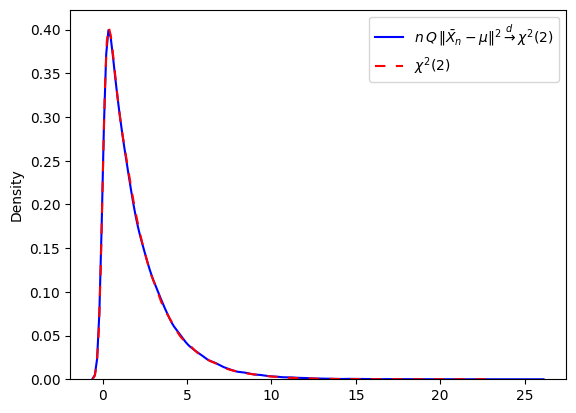

In [358]:
clt_extension_multi_variate()

### **4. Probability Simulator**

###### **In this problem we want to see how simulation can help us to find the area of bounded curve. To do so, suppose we have a function $y = f(x)$ defined in $[0,1]$. Use Monte-Carlo simulation method by drawing samples and calculate the area under the curve $f(x)$ with two different approach. Then use your code and find an estimation for number $\pi$**
###### Method 1: We need to randomly generate (x,y) points, then calculate the probabilty of (x,y) < curve, and finally scale this probability by the area that circumscribe the function.
 ###### Method 2: Let's say $I = \int f(x) dx$, we know that $E[f(x)] = \int f(x) g(x) dx$ where $g(x)$ is a distribution, let's say uniform, then $$\hat I = \dfrac{1}{n} \Sigma f(x_i) \times scaling$$ where $x_i$ is coming from $g(x)$. In the case of $g(x) \sim uniform(a,b)$ the $scaling = (b-a)$


In [613]:
class MonteCarloSim():
    
    def __init__(self, n, func, domain_lower, domain_higher):
        self.n = n
        self.func = func
        self.domain_lower = domain_lower
        self.domain_higher = domain_higher
        self.x = cp.random.uniform(low = self.domain_lower, high = self.domain_higher, size = self.n)
        
    def method_one(self):
        curve = self.func(self.x)
        y_upper = curve.max() + 1e-5
        y_lower = curve.min() - 1e-5
        y = cp.random.uniform(low = y_lower, high = y_upper, size = self.n)
        
        prob_under_curve = (y<=curve).mean()                                   #((curve<0) & (y>curve) & (y<0)).mean() + ((curve>0) & (y<curve) & (y>0)).mean()
        whole_area = (self.domain_higher - self.domain_lower) * (y_upper - y_lower)
        area_under_curve = prob_under_curve * whole_area

        sns.lineplot(x=self.x.get(),y=curve.get(), color='darkblue', label='Function', lw=1)
        sns.scatterplot(x=self.x[y<=curve].get(),y=y[y<=curve].get(), s=5, color='skyblue')
        sns.scatterplot(x=self.x[y>curve].get(),y=y[y>curve].get(), s=5, color='orange')
        plt.vlines(x=self.domain_lower, ymin=y_lower.item(), ymax=y_upper.item(), color='red', lw=1)
        plt.vlines(x=self.domain_higher, ymin=y_lower.item(), ymax=y_upper.item(), color='red', lw=1)
        plt.hlines(xmin=self.domain_lower, xmax=self.domain_higher, y=y_lower.item(), color='red', lw=1)
        plt.hlines(xmin=self.domain_lower, xmax=self.domain_higher, y=y_upper.item(), color='red', lw=1)
        plt.hlines(xmin=self.domain_lower, xmax=self.domain_higher, y=0, color='green', lw=2, ls='--')
        plt.title(f'Area under curve is: {area_under_curve:.4f}')
        plt.legend(bbox_to_anchor=(1,1))
        plt.show()

        return area_under_curve
    
    def method_two(self):
        h_i = self.func(self.x)
        area_under_curve = h_i.mean() * (self.domain_higher - self.domain_lower)     
        return area_under_curve
    
    def pi_calculation(self):
        assert -self.domain_lower == self.domain_higher, "lower bound and upper bound of a circle function should be -r and r"
        y = cp.random.uniform(low = self.domain_lower, high = self.domain_higher, size = self.n)
        whole_area = (self.domain_higher - self.domain_lower)**2
        within_circle = (self.x**2 + y**2 <= self.domain_higher**2).mean()
        area_under_curve = within_circle*whole_area
        pi = area_under_curve/(self.domain_higher**2)

        sns.scatterplot(x=self.x[self.x**2 + y**2 <= self.domain_higher**2].get(),y=y[self.x**2 + y**2 <= self.domain_higher**2].get(), s=5, color='red')
        sns.scatterplot(x=self.x[self.x**2 + y**2 > self.domain_higher**2].get(),y=y[self.x**2 + y**2 > self.domain_higher**2].get(), s=5, color='blue')
        plt.title(f'Area of Circle = {area_under_curve:.4f}     $\pi$ = {pi:.4f}')
        plt.gcf().set_size_inches(4,4)

        return pi, area_under_curve


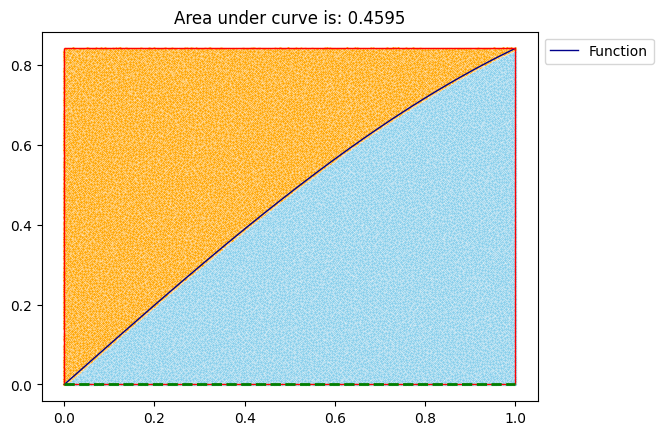

array(0.45945145)

In [604]:
MonteCarloSim(int(1e6), lambda x: cp.sin(x), 0, 1).method_one()

In [605]:
MonteCarloSim(int(1e6), lambda x: cp.sin(x), 0, 1).method_two()

array(0.45982524)

(array(3.14166192), array(3.14166192))

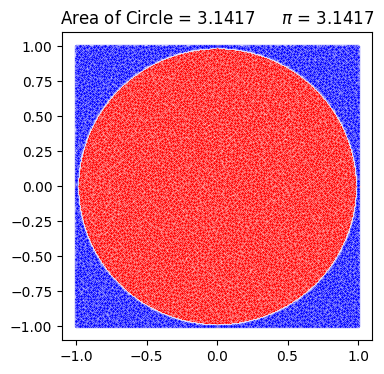

In [618]:
MonteCarloSim(int(1e8), lambda x: cp.sin(x), -1, 1).pi_calculation()

### **5. Monte-Carlo Simulation**

###### **Suppose $x$ has a normal distribution $N(0,1)$. Use Monte-Carlo simulation with $N = 10, \, 100, \,1000, \,10000, \,1000000$ samples to calculate the followings. report the time needed to solve each of them using vector based method or using for loops.**
###### **1. $E[exp(x)]$** 
###### **2. $Var[exp(x)]$**
###### **3. $E[x^4]$**
###### **4. Redo above but assume $x$ has a Standard Beta distribution.**
###### **5. Redo above but assume x has a exponential distribution. Draw the samples using your own code and not the Python built-in code.**

In [668]:
def monte_carlo_sim(n, dist, method, func):
    
    if 'normal' == str(dist).split()[1]:
        params = [0,1]
    else:
        params = [1,1]

    if 'exponential' == str(dist).split()[1]:
        if method == 'loop':
            start = time.time()
            sample = cp.zeros(n)
            for i in range(n):
                u_i = cp.random.rand()
                sample[i] = -cp.log(1-u_i)/params[1]
            sample_func = func(sample)
            expectation = sample_func.mean()
            variance = sample_func.var()
            end = time.time()
            time_taken = end - start
        elif method == 'vector':
            start = time.time()
            u_i = cp.random.rand(n)
            sample = -cp.log(1-u_i)/params[1]
            sample_func = func(sample)
            expectation = sample_func.mean()
            variance = sample_func.var()            
            end = time.time()
            time_taken = end - start    

    else:
        if method == 'loop':
            start = time.time()
            sample = cp.zeros(n)
            for i in range(n):
                sample[i] = dist(params[0], params[1], size = 1)
            sample_func = func(sample)
            expectation = sample_func.mean()
            variance = sample_func.var()
            end = time.time()
            time_taken = end - start
        elif method == 'vector':
            start = time.time()
            sample = dist(params[0], params[1], size = n)
            sample_func = func(sample)
            expectation = sample_func.mean()
            variance = sample_func.var()
            end = time.time()
            time_taken = end - start    

    
    return expectation, variance, time_taken


In [731]:
ns = [10**i for i in range(1,7)]
dists = [cp.random.normal, cp.random.beta, cp.random.exponential]
methods = ['loop', 'vector']
functions = {'exponential':lambda x: cp.exp(x), 'x^4':lambda x: x**4}

for dist in dists:
    for method in methods:
        for name_func,func in functions.items():
            for n in ns:
                expectation, variance, time_taken = monte_carlo_sim(n, dist, method, func)
                print(f'Distribution: {str(dist).split()[1]} | method: {method} | n: {n} | Time: {time_taken:.2f} Seconds | E = {expectation:.4f} | Var = {variance:.4f} | function: {name_func}')
                print('-'*200)

Distribution: normal | method: loop | n: 10 | Time: 0.00 Seconds | E = 0.9995 | Var = 1.0859 | function: exponential
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Distribution: normal | method: loop | n: 100 | Time: 0.01 Seconds | E = 1.4926 | Var = 4.1938 | function: exponential
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Distribution: normal | method: loop | n: 1000 | Time: 0.06 Seconds | E = 1.6099 | Var = 4.4662 | function: exponential
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Distribution: normal | method: loop | n: 10

### **6. Monte-Carlo simulation distribution**

###### **Suppose $x$ has a normal distribution $N(0,1)$. Use Monte-Carlo simulation with $N = 10$ samples to calculate $E[exp(x)]$. Name this random variable $\hat I$. Try your Monte Carlo simulation 10000 times and plot the histogram of the $\hat I$: Find the variance of this distribution as well. Finally, redo this exercise for $N = 10^k$ whre $k = 1, 2, 3, 4, 5, 6$ and plot the variance with respect to $N$:**

In [892]:
def monte_carlo_sim(n, k=10_000):
    i_hat = cp.zeros(k)
    for i in range(k):
        i_hat[i] = cp.exp(cp.random.normal(loc=0, scale=1, size=n)).mean()
    var_i_hat = i_hat.var()
    e_i_hat = i_hat.mean()
    sns.histplot(i_hat.get(), kde=True)
    plt.title(f'Var = {var_i_hat.get():.3f} | E = {e_i_hat.get():.3f} | N = {n}', fontsize=10)

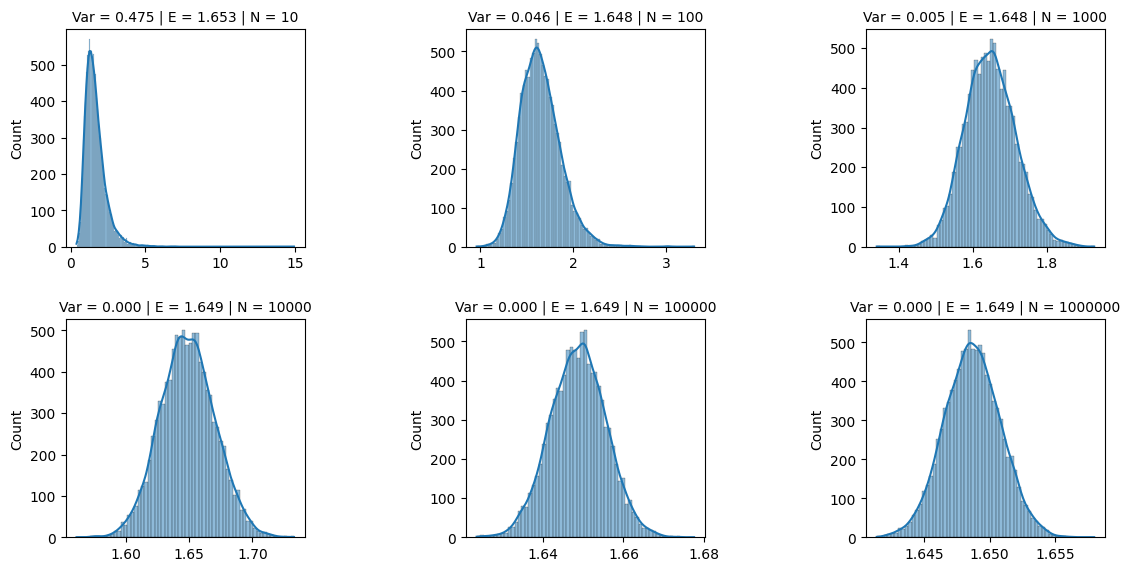

In [893]:
ns = [10**i for i in range(1,7)]
for i,n in enumerate(ns):
    plt.subplot(2,3,i+1)
    monte_carlo_sim(n)
plt.tight_layout()
plt.gcf().set_size_inches(12,6) 
plt.show()

### **7. Monte-Carlo in Higher Dimensions**

###### **1. Suppose $x_i$ for $i = 1, 2, ..., 10$ has a normal distribution $Normal \sim (0,1)$. Calculate  $\large E[\sum_{i=1}^{10} x_i^2]$.**
###### **2. Use Monte-Carlo method and calculate $\large \int_{z=0}^1 \int_{y=0}^1 \int_{x=0}^1 \sqrt{x^2 + 3y^2 + 5z^2} \; dx dy dz$. How many samples are needed to receive a $\large 10^{-3}$ preciseness.**

In [906]:
def higher_dimension(k,n, func):
    sample = cp.random.normal(0,1,(k,n))
    samle_func = func(sample)
    return samle_func.mean(-1).sum().item()

In [912]:
higher_dimension(10,10_000_000,lambda x: x**2)

10.000358105346109

In [ ]:
#As the standard deviation is proportional to 1/sqrt(n), to get a preciseness of 10^-3 we need ~ 10^6 samples.
def triple_integral(n, func):
    x, y, z = cp.random.rand(n), cp.random.rand(n), cp.random.rand(n)
    h_i = func(x,y,z)
    return h_i.mean() 

In [931]:
triple_integral(1_000_000, lambda x,y,z: cp.sqrt(x**2 + 3*y**2 + 5*z**2))

array(1.64396659)

In [932]:
triple_integral(100_000_000, lambda x,y,z: cp.sqrt(x**2 + 3*y**2 + 5*z**2))

array(1.64496524)

In [937]:
#A more empirical way to answer the number of N
preciseness = 1e-3
repetition = 100
n_candidates = [10**i for i in [4,5,6,7]]
for n in n_candidates:
    repetition_outputs = cp.zeros(repetition)
    for i in range(repetition):
        repetition_outputs[i] = triple_integral(n, lambda x,y,z: cp.sqrt(x**2 + 3*y**2 + 5*z**2))
    if repetition_outputs.std().item() < preciseness:
        print(f'n:{n} | std:{repetition_outputs.std().item():.10f}  we got the preciseness we wanted')
    else:
        print(f'n:{n} | std:{repetition_outputs.std().item():.10f}')    

n:10000 | std:0.0052250333
n:100000 | std:0.0018453922
n:1000000 | std:0.0005402245  we got the preciseness we wanted
n:10000000 | std:0.0001620868  we got the preciseness we wanted


### **8. Simulating a Household**

###### **In this problem, we would like to see how simulations can help us address aggregation issues in macroeconomics where heterogeneity exists or simple classic aggregation assumptions do not hold. Consider Household $i$ $(HH_i)$ with preferences over consumption and leisure $$\large U_i = \dfrac{C^{1-\sigma}}{1-\sigma} - \gamma \dfrac{l^{1+\phi}}{1+\phi}$$ and and maximizes it subject to $$\large pC = wl + T$$ where $l$ is the labor supplied. Take $T$ = 10**

###### **1. Solve the $(HH_i)$ problem analytically.**

###### $\large \nabla C = \lambda \nabla g \implies \begin{pmatrix} C^{-\sigma} \\  \\ -\gamma \, l^\phi \end{pmatrix} = \lambda \, \begin{pmatrix} p \\  \\ -w \end{pmatrix} \implies \begin{cases} C^{-\sigma} = \lambda \, p \implies \lambda = \dfrac{C^{-\sigma}}{p}\\ \\ \gamma \, l^\phi = \lambda \, w \implies \lambda = \dfrac{\gamma \, l^\phi}{w} \\ \\ pC = wl + T \implies C = \dfrac{wl + T}{p} \implies C = \dfrac{w}{p} \, l + \dfrac{T}{p} \implies l = (C - \dfrac{T}{p}) \, \dfrac{p}{w} \end{cases} \implies \dfrac{w}{p} = \gamma \, ((C - \dfrac{T}{p}) \, \dfrac{p}{w})^\phi \, C^\sigma \implies \log{\dfrac{w}{p}} = \log{\gamma} + \phi \, \log{C - \dfrac{T}{p}} - \phi \, log{\dfrac{w}{p}} + \sigma \, \log{C}$

###### Equation that need to be solved to get consumption is: $$\huge \log{\gamma} + \phi \, \log{(C - \dfrac{T}{p})} - \phi \, log{\dfrac{w}{p}} + \sigma \, \log{C} - \log{\dfrac{w}{p}} = 0$$ and to get labor supply $$\huge l = \exp{(\log{(C - \dfrac{T}{p}) - \log{\dfrac{w}{p}}})}$$

###### **2. Assume that $\log \dfrac{w}{p}$ is is randomly distributed such that $\log \dfrac{w}{p} \sim Normal(3,2)$. Again simulate this economy and find the aggregate consumption. You can take $\sigma = 0.3 \, , \, \phi = 1.4 \, , \, \gamma = 1.2$ Plot the histogram of consumption and labor supply in this economy. Find the aggregate consumption and labor supply.**

###### **3. Now instead, assume that $\phi$ is randomly distributed such that $\phi \sim Uniform(0.3,3.3)$. Again simulate this economy and find the aggregate consumption and labor supply. You can take $\sigma = 0.3 \, , \, \log \dfrac{w}{p} = 3 \, , \, \gamma = 1.2$ Plot the histogram of consumption and labor supply in this economy. Find the aggregate consumption and labor supply.**

###### **4. Now assume all $\log \dfrac{w}{p}$ and $\phi$ are random with the above distributions and are independent of each other. Simulate this economy and find the aggregate consumption and labor supply. You can take $\sigma = 0.3 \, , \, \gamma = 1.2$. Plot the histogram of consumption and labor supply in this economy. Find the aggregate consumption and labor supply.**

###### **5. Now redo part 2, with the assumption that $T$ has an independent normal distribution $N \sim (10,2)$**


In [1110]:
def household_1(n):
    
    consumption = cp.zeros(n)
    labor = cp.zeros(n)
    gamma = 1.2
    phi = 1.4
    t = 10
    sigma = 0.3

    for i in tqdm(range(n)):
        
        log_w_p = cp.random.normal(3,np.sqrt(2),1)

        def equation(c):
            return np.log(gamma) + phi * np.log(c - t) - phi * log_w_p.item() + sigma * np.log(c) - log_w_p.item()

        guess = np.exp(log_w_p.item()) + t

        consumption_solved = fsolve(equation, guess)

        consumption[i] = consumption_solved[0]
        labor[i] = cp.exp(cp.log(consumption_solved[0] - t) - log_w_p)

    return consumption.get(), labor.get()


In [1111]:
consumption , labor = household_1(int(1e5))

100%|██████████| 100000/100000 [01:18<00:00, 1271.76it/s]


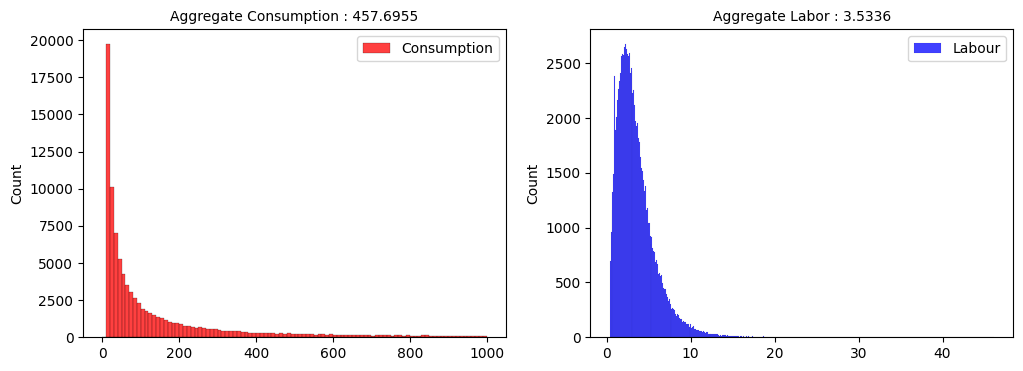

In [1122]:
plt.subplot(1,2,1)
sns.histplot(consumption, label = 'Consumption', color='red', binrange=(0, 1_000), bins=100)
plt.title(f'Aggregate Consumption : {consumption.mean().item():.4f}', fontsize=10)
plt.legend()
plt.subplot(1,2,2)
sns.histplot(labor, label = 'Labour', color='blue')
plt.title(f'Aggregate Labor : {labor.mean().item():.4f}', fontsize=10)
plt.legend()
plt.gcf().set_size_inches(12,4)
plt.show()

100%|██████████| 100000/100000 [01:06<00:00, 1499.57it/s]


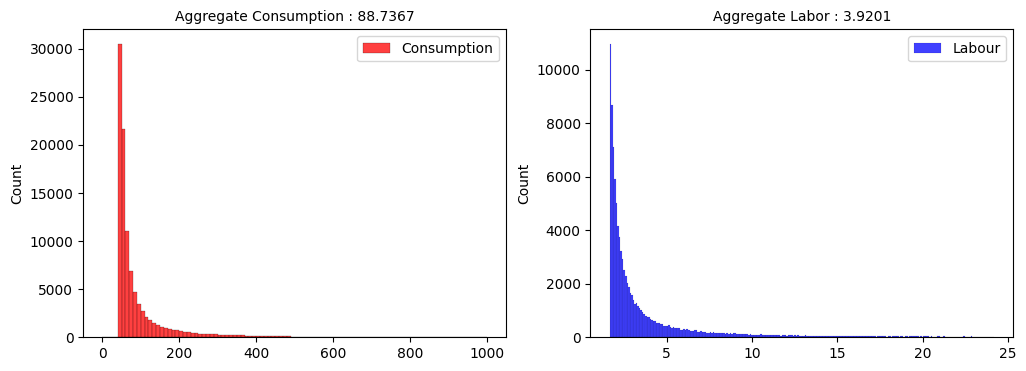

In [1125]:
def household_2(n):
    
    consumption = cp.zeros(n)
    labor = cp.zeros(n)
    gamma = 1.2
    t = 10
    sigma = 0.3
    log_w_p = 3

    for i in tqdm(range(n)):
        
        phi = cp.random.uniform(0.3,3.3,1)
        
        def equation(c):
            return np.log(gamma) + phi.item() * np.log(c - t) - phi.item() * log_w_p + sigma * np.log(c) - log_w_p

        guess = np.exp(log_w_p) + t

        consumption_solved = fsolve(equation, guess)

        consumption[i] = consumption_solved[0]
        labor[i] = cp.exp(cp.log(consumption_solved[0] - t) - log_w_p)

    return consumption.get(), labor.get()

consumption , labor = household_2(int(1e5))

plt.subplot(1,2,1)
sns.histplot(consumption, label = 'Consumption', color='red', binrange=(0, 1_000), bins=100)
plt.title(f'Aggregate Consumption : {consumption.mean().item():.4f}', fontsize=10)
plt.legend()
plt.subplot(1,2,2)
sns.histplot(labor, label = 'Labour', color='blue')
plt.title(f'Aggregate Labor : {labor.mean().item():.4f}', fontsize=10)
plt.legend()
plt.gcf().set_size_inches(12,4)
plt.show()

100%|██████████| 100000/100000 [01:40<00:00, 993.52it/s]


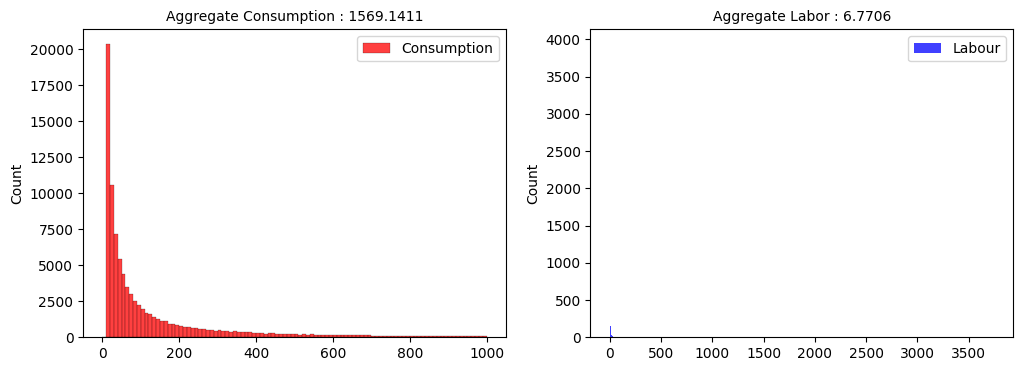

In [1127]:
def household_3(n):
    
    consumption = cp.zeros(n)
    labor = cp.zeros(n)
    gamma = 1.2
    t = 10
    sigma = 0.3

    for i in tqdm(range(n)):
        
        log_w_p = cp.random.normal(3,np.sqrt(2),1)
        phi = cp.random.uniform(0.3,3.3,1)
        
        def equation(c):
            return np.log(gamma) + phi.item() * np.log(c - t) - phi.item() * log_w_p.item() + sigma * np.log(c) - log_w_p.item()

        guess = np.exp(log_w_p.item()) + t

        consumption_solved = fsolve(equation, guess)

        consumption[i] = consumption_solved[0]
        labor[i] = cp.exp(cp.log(consumption_solved[0] - t) - log_w_p)

    return consumption.get(), labor.get()

consumption , labor = household_3(int(1e5))

plt.subplot(1,2,1)
sns.histplot(consumption, label = 'Consumption', color='red', binrange=(0, 1_000), bins=100)
plt.title(f'Aggregate Consumption : {consumption.mean().item():.4f}', fontsize=10)
plt.legend()
plt.subplot(1,2,2)
sns.histplot(labor, label = 'Labour', color='blue')
plt.title(f'Aggregate Labor : {labor.mean().item():.4f}', fontsize=10)
plt.legend()
plt.gcf().set_size_inches(12,4)
plt.show()

100%|██████████| 100000/100000 [01:52<00:00, 887.72it/s]


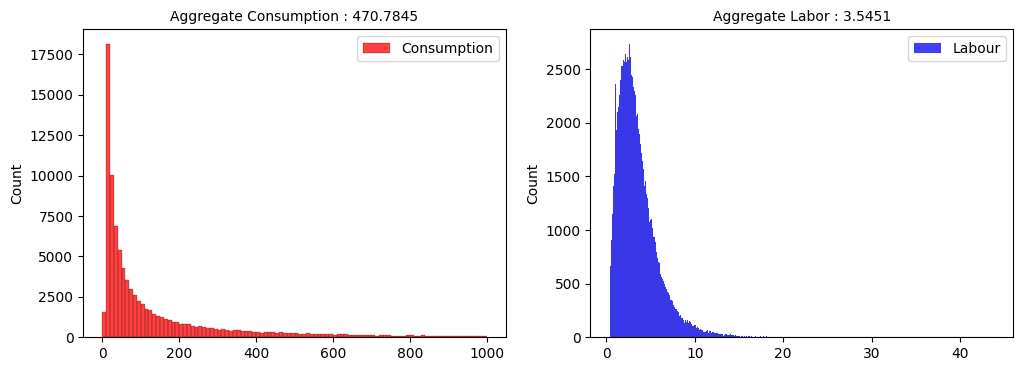

In [1128]:
def household_4(n):
    
    consumption = cp.zeros(n)
    labor = cp.zeros(n)
    gamma = 1.2
    phi = 1.4
    sigma = 0.3

    for i in tqdm(range(n)):
        
        log_w_p = cp.random.normal(3,np.sqrt(2),1)
        t = cp.random.normal(10,np.sqrt(2),1)

        def equation(c):
            return np.log(gamma) + phi * np.log(c - t.item()) - phi * log_w_p.item() + sigma * np.log(c) - log_w_p.item()

        guess = np.exp(log_w_p.item()) + t.item()

        consumption_solved = fsolve(equation, guess)

        consumption[i] = consumption_solved[0]
        labor[i] = cp.exp(cp.log(consumption_solved[0] - t) - log_w_p)

    return consumption.get(), labor.get()

consumption , labor = household_4(int(1e5))

plt.subplot(1,2,1)
sns.histplot(consumption, label = 'Consumption', color='red', binrange=(0, 1_000), bins=100)
plt.title(f'Aggregate Consumption : {consumption.mean().item():.4f}', fontsize=10)
plt.legend()
plt.subplot(1,2,2)
sns.histplot(labor, label = 'Labour', color='blue')
plt.title(f'Aggregate Labor : {labor.mean().item():.4f}', fontsize=10)
plt.legend()
plt.gcf().set_size_inches(12,4)
plt.show()